# 3.5 Hyperparameter Tuning

The choice of model parameters that is optimal for the specific problem can be found automatically by searching the model parameter space. The type of algorithm is fixed in this instance.

There are built-in toolkits to perform the hyperparameter search.

In [2]:
# basic tools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wget
import h5py
import pandas as pd
import os

In this example, we will use the classification example of event discrimination using seismic data.

In [3]:
wget.download("https://www.dropbox.com/s/qwo2rh5zqwho1l5/miniPNW_metadata.csv?dl=1")
wget.download("https://www.dropbox.com/s/ie34kfu33d2jv9m/miniPNW_waveforms.hdf5?dl=1")
os.replace("miniPNW_metadata.csv","../../miniPNW_metadata.csv")
os.replace("miniPNW_waveforms.hdf5","../../miniPNW_waveforms.hdf5")

Read the metadata. We will pick the source_type as a categorical class that we aim to classify the data into

In [19]:

# read the metadata
df = pd.read_csv("../../miniPNW_metadata.csv")
df

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,source_magnitude,source_magnitude_type,source_magnitude_uncertainty,source_depth_uncertainty_km,...,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_onset,trace_P_arrival_uncertainty_p,trace_P_arrival_uncertainty_s,trace_P_polarity,trace_S_onset,trace_P_onset.1,split
0,uw61778532,2021-10-07T01:07:00.890000Z,48.297,-121.875,earthquake,6.61,0.75,ml,0.029,1.55,...,100,2021-10-07T01:06:10.890000Z,5968.0,5535.0,0.15,0.06,negative,emergent,impulsive,-0.016|3.238|-1.782
1,uw61694752,2020-12-10T07:27:39.710000Z,46.876,-121.961,earthquake,6.05,0.38,ml,0.170,0.41,...,100,2020-12-10T07:26:49.710000Z,5447.0,5247.0,0.06,0.03,positive,impulsive,impulsive,2.228|-0.148|-1.71
2,uw61534491,2019-07-09T18:09:29.980000Z,45.317,-121.720,earthquake,4.69,1.20,ml,0.323,0.53,...,100,2019-07-09T18:08:39.980000Z,5312.0,5180.0,0.06,0.03,positive,impulsive,impulsive,15.602|16.858|16.695
3,uw61573667,2020-02-12T11:38:12.820000Z,48.711,-123.108,earthquake,59.91,2.02,ml,0.098,1.07,...,100,2020-02-12T11:37:22.820000Z,7609.0,6501.0,0.15,0.06,negative,emergent,impulsive,6.869|4.454|0.464
4,uw61784657,2021-10-29T15:42:17.210000Z,46.150,-122.459,earthquake,15.17,1.67,ml,0.199,1.36,...,100,2021-10-29T15:41:27.210000Z,6373.0,5737.0,0.06,0.15,undecidable,impulsive,emergent,3.938|-0.063|3.206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,pnsn1095068,NaN,NaN,NaN,probable explosion,NaN,NaN,NaN,NaN,NaN,...,100,2010-09-18T00:29:34.000000Z,NaN,7000.0,NaN,NaN,NaN,NaN,impulsive,-3.022|-2.384|2.735
1416,pnsn2157848,NaN,NaN,NaN,probable explosion,NaN,NaN,NaN,NaN,NaN,...,100,2015-06-12T16:25:49.000000Z,NaN,7000.0,NaN,NaN,NaN,NaN,emergent,-2.991|2.091|0.790
1417,pnsn988978,NaN,NaN,NaN,probable explosion,NaN,NaN,NaN,NaN,NaN,...,100,2006-09-24T21:13:50.000000Z,NaN,7000.0,NaN,NaN,NaN,NaN,impulsive,-9.986|-4.502|5.091
1418,pnsn2123243,NaN,NaN,NaN,probable explosion,NaN,NaN,NaN,NaN,NaN,...,100,2015-05-05T19:16:09.000000Z,7600.0,7000.0,NaN,NaN,NaN,emergent,impulsive,-2.497|5.717|1.740


In [15]:
list(df.keys())

['event_id',
 'source_origin_time',
 'source_latitude_deg',
 'source_longitude_deg',
 'event_type',
 'source_depth_km',
 'source_magnitude',
 'source_magnitude_type',
 'source_magnitude_uncertainty',
 'source_depth_uncertainty_km',
 'source_horizontal_uncertainty_km',
 'station_network_code',
 'trace_channel',
 'station_code',
 'station_location_code',
 'station_latitude_deg',
 'station_latitude_deg.1',
 'station_longitude_de',
 'trace_name',
 'trace_sampling_rate_hz',
 'trace_start_time',
 'trace_S_arrival_sample',
 'trace_P_onset',
 'trace_P_arrival_uncertainty_p',
 'trace_P_arrival_uncertainty_s',
 'trace_P_polarity',
 'trace_S_onset',
 'trace_P_onset.1',
 'split']

Create the array of labels

['earthquake' 'explosion' 'probable explosion' 'sonic boom'
 'surface event' 'thunder']


(array([300.,   0., 300.,   0., 126.,   0.,  94.,   0., 300., 300.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

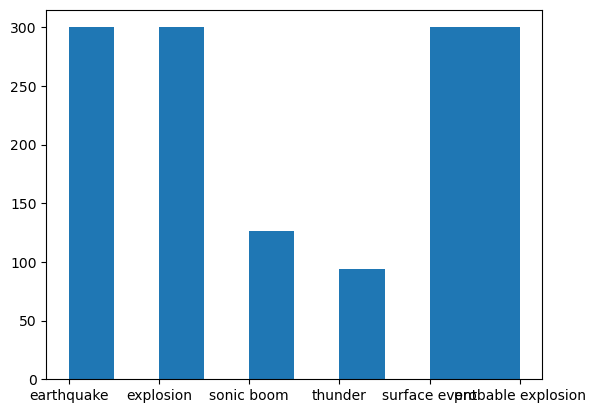

In [22]:
labels = df['source_type']

How much data is there?

In [45]:
df.describe()

,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_uncertainty,source_depth_uncertainty_km,source_horizontal_uncertainty_km,station_latitude_deg,station_latitude_deg.1,station_longitude_de,trace_sampling_rate_hz,trace_S_arrival_sample,trace_P_onset,trace_P_arrival_uncertainty_p,trace_P_arrival_uncertainty_s
count,600.000000,600.000000,600.000000,600.000000,592.000000,600.000000,600.000000,1420.000000,1420.000000,1420.000000,1420.0,782.000000,1389.000000,600.000000,598.000000
mean,46.853985,-121.806967,5.699785,1.437267,0.146677,15.827117,1.191217,46.110538,-121.671953,1112.625352,100.0,6814.869565,6504.869690,0.105867,0.089114
std,1.708874,1.409521,9.755103,0.675367,0.098178,15.996679,2.967017,1.853370,1.173497,793.182631,0.0,1156.627166,709.001874,0.063500,0.062169
min,41.829000,-126.824000,-2.580000,0.000000,0.001000,0.000000,0.000000,41.392000,-125.365000,-40.000000,100.0,5069.000000,4999.000000,0.010000,0.010000
25%,46.143750,-122.706750,-0.540000,0.970000,0.078750,0.680000,0.410000,44.055625,-122.224000,364.000000,100.0,5886.750000,5819.000000,0.060000,0.050000
50%,46.961000,-122.018500,-0.170000,1.430000,0.133500,3.185000,0.627000,46.237500,-121.810000,977.100000,100.0,6747.500000,7000.000000,0.060000,0.060000
75%,47.881250,-121.001250,9.835500,1.870000,0.190000,31.610000,1.317500,47.534700,-121.233000,1743.000000,100.0,7515.000000,7000.000000,0.150000,0.150000
max,49.531000,-116.576000,72.234000,3.940000,0.909000,99.900000,64.425000,50.126600,-117.123000,3085.000000,100.0,14757.000000,10059.000000,0.350000,0.400000


How many classes are there?

['earthquake' 'explosion' 'probable explosion' 'sonic boom'
 'surface event' 'thunder']
6


(array([300.,   0., 300.,   0., 126.,   0.,  94.,   0., 300., 300.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

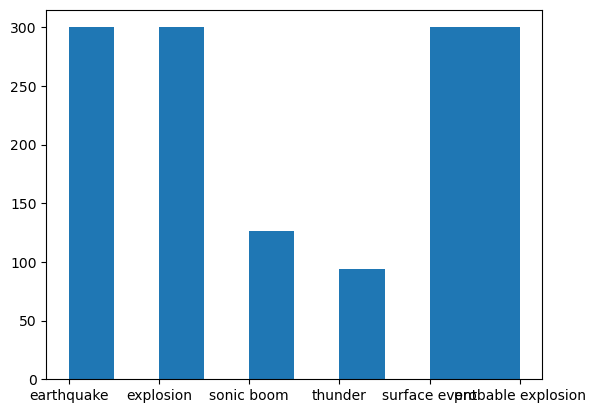

In [24]:
print(np.unique(labels))
print(len(np.unique(labels)))
plt.hist(labels)

There are 6 classes. The data looks quite imbalanced. This is because the seismic networks will preferably pick earthquakes.

Now are read the data. It is stored in an HDF5 files under a finite number of groups. Each groups has an array of datasets that correspond to the waveforms. To link the metadata to the waveform files, the key ``trace_name`` has the dataset ID. The address is labeled as follows: 

bucketX$i,:3,:n

where X is the HDF5 group number, i is the index


In [25]:
f = h5py.File("../../miniPNW_waveforms.hdf5", "r")

In [58]:
def read_data(tn,f):
    bucket, narray = tn.split('$')
    x, y, z = iter([int(i) for i in narray.split(',:')])
    print(f['/data/%s' % bucket].shape)
    data = f['/data/%s' % bucket][x, :y, :z]
    return data

In [27]:
ldata=list(df['trace_name'])

In [46]:
crap=read_data(ldata[40],f)
print(crap.shape)

(3, 15001)


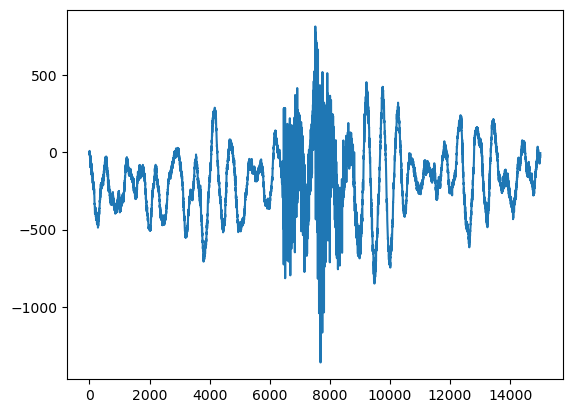

In [47]:
plt.plot(crap[2,:])

We will just extract the Z component and reshape them into a single array.

In [59]:
nt=crap.shape[-1]
ndata=len(labels)
print(ndata,nt)
Z=np.zeros(shape=(ndata,nt))
for i in range(ndata-1):
    # print(df.iloc[i]["trace_name"])
    print("Done at %f"%(i/ndata))
    Z[i,:]=read_data(df.iloc[i]["trace_name"],f)[2,:nt]


1420 15001
Done at 0.000000
(300, 3, 15001)
Done at 0.000704
(300, 3, 15001)
Done at 0.001408
(300, 3, 15001)
Done at 0.002113
(300, 3, 15001)
Done at 0.002817
(300, 3, 15001)
Done at 0.003521
(300, 3, 15001)
Done at 0.004225
(300, 3, 15001)
Done at 0.004930
(300, 3, 15001)
Done at 0.005634
(300, 3, 15001)
Done at 0.006338
(300, 3, 15001)
Done at 0.007042
(300, 3, 15001)
Done at 0.007746
(300, 3, 15001)
Done at 0.008451
(300, 3, 15001)
Done at 0.009155
(300, 3, 15001)
Done at 0.009859
(300, 3, 15001)
Done at 0.010563
(300, 3, 15001)
Done at 0.011268
(300, 3, 15001)
Done at 0.011972
(300, 3, 15001)
Done at 0.012676
(300, 3, 15001)
Done at 0.013380
(300, 3, 15001)
Done at 0.014085
(300, 3, 15001)
Done at 0.014789
(300, 3, 15001)
Done at 0.015493
(300, 3, 15001)
Done at 0.016197
(300, 3, 15001)
Done at 0.016901
(300, 3, 15001)
Done at 0.017606
(300, 3, 15001)
Done at 0.018310
(300, 3, 15001)
Done at 0.019014
(300, 3, 15001)
Done at 0.019718
(300, 3, 15001)
Done at 0.020423
(300, 3, 15001)

IndexError: Index (300) out of range for (0-299)